In [1]:
from qiskit import *
import numpy as np
import itertools as it
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.visualization import plot_bloch_multivector

This function implements a quantum fourier transform on a circuit.

In [2]:
def QFT_inv(circ, n):
    '''
    This function applies the quantum Fourier function on qubit 0 through n
    with inverse output, ie what should be 0011 is instead 1100.
    
    paramaters:
    param circ - The qiskit circuit that the QFT circuit is to be applied to
    param n - The last qubit to apply gates on
    '''
    
    #This checks if all qubits have been gone over
    if n!= 0:
        #Move to the next qubits and apply appropriate gates
        n -= 1
        circ.h(n)
        for q in np.arange(n):
            circ.cp(np.pi/2**(n-q), q, n)
    
        #Repeat function   
        QFT_inv(circ, n)

    return circ

def QFT(circ, n):
    '''
    This function applies the quantum Fourier function on qubit 0 through n
    This corresponds to equation 39 and figure 6 and 7.
    
    paramaters:
    param circ - The qiskit circuit that the QFT circuit is to be applied to
    param n - The initial qubit to apply gates on
    '''
    
    #First we apply the QFT tranformation
    circ = QFT_inv(circ, n)
    
    #The qubits are then swapped with the qubit on the opposite side of
    #the circuit.
    circ.barrier()
    for i in np.arange(n//2):
        circ.swap(i, n-1-i)
            
    #Ends the function returning the circuit with the QFT applied
    return circ

We run a test of the QFT, to ensure it properly transforms the integer 9, 1001 in binary.

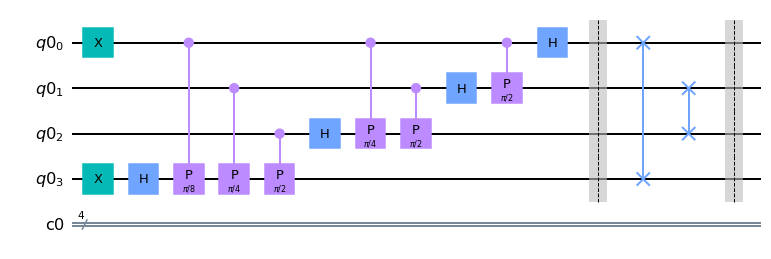

In [3]:
cr = ClassicalRegister(4)
qr = QuantumRegister(4)
test_QFT = QuantumCircuit(qr, cr)

test_QFT.x((0, 3))
test_QFT.barrier

QFT(test_QFT, 4)
test_QFT.barrier()

test_QFT.draw(output = 'mpl')

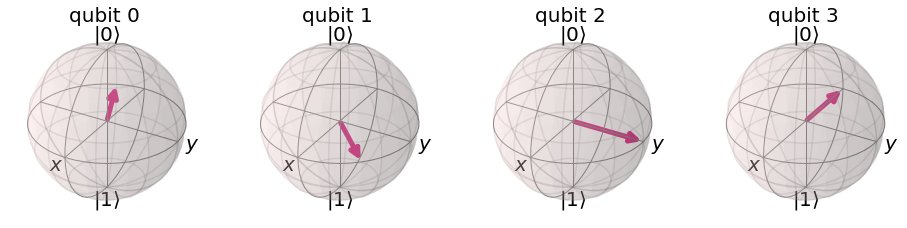

In [4]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(test_QFT)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

And here is similarly implemented a function for inverse quantum fourier transform on a circuit.

In [5]:
#As it will be used in the Phase Estimation, I define the QFT_dagger function.
def QFT_dagger(circ, n):
    '''
    This function applies the inverse quantum Fourier function on qubit 0 through n
    
    paramaters:
    param circ - The qiskit circuit that the inverse QFT circuit is to be applied to
    param n - The initial qubit to apply gates on
    '''
    
    #First we swap the qubits, since the rest of the QFT_dagger returns
    #an "inverse" state
    for i in np.arange(n//2):
        #We swap to make up for the implementations inverted nature
        circ.swap(i, n-1-i)
    
    #We then apply the relevant Hadamard and phase gates.
    for i in np.arange(n):
        for j in np.arange(i):
            circ.cp(-np.pi/2**(i-j), j, i)
        circ.h(i)

    #Ends the function returning the circuit with the inverse QFT applied
    return circ

This runs the QFT and Inverse QFT, showing that they are in fact each others inverse.

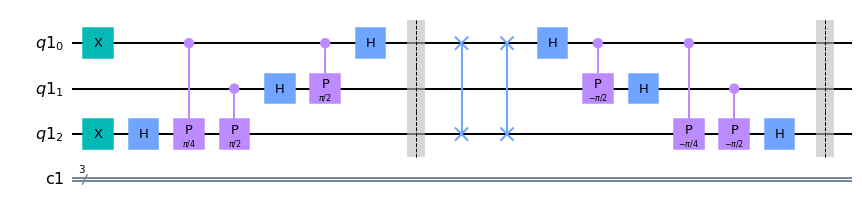

In [6]:
qubits = 3
cr = ClassicalRegister(qubits)
qr = QuantumRegister(qubits)
test_QFT = QuantumCircuit(qr, cr)

test_QFT.x((0, qubits-1))
test_QFT.barrier

QFT(test_QFT, qubits)
QFT_dagger(test_QFT, qubits)
test_QFT.barrier()

test_QFT.draw(output = 'mpl')

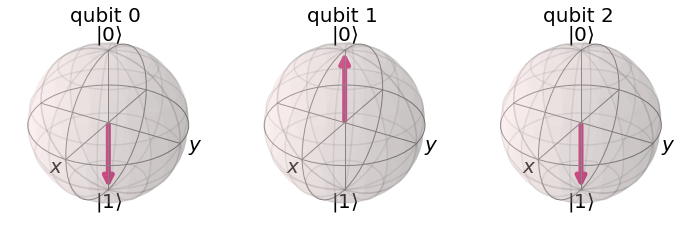

In [7]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(test_QFT)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

Before defining the phase estimation, I define the trotter decomposition used in the phase estimation, to allow me to calculate the phase of my unitary U. I define 3 functions that together are supposed to decompose a 2^N by 2^N Hermitian matrix into a sum of pauli vectors and thereafter apply it to the circuit via trotter decomposition

The first function, pauli_traces is the one that calculates how much of each pauli product is supposed to be used in the implementation of the Hamiltonian.

The second function exp_product is the one that applies one of the pauli products to the circuit with corresponding phase.

The third function is the one that employs the decomposed Hamiltonian in the form of $U = (e^{i H_1 t/r}e^{i H_2 t/r}...e^{i H_m t/r})^r$. It does so using both of the pauli_traces and exp_product functions. It repeats it r times, where r is the Trotter number. It can be made to be controlled by defigning

In [17]:
def pauli_traces(H):
    '''
    This function finds the trace coefficients for the Pauli decomposition
    of a Hamiltonian H, in accordance with equation 22.
    
    paramaters:
    param H - The Hamiltonian matrix to find coefficients for
    '''
    
    n = np.log2(H.shape[0]) 
    
    #First I define the array that contains my pauli gates
    IXYZ = np.array([
    [[1,0],[0,1]],    # I
    [[0,1],[1,0]],    # X
    [[0,-1j],[1j,0]], # Y
    [[1,0],[0,-1]]    # Z
    ],dtype="complex")

    #The n = 0 identity is defined so that the further calculations below
    #result 
    tensors = np.array([[[1]]])
    
    #I calculate all the possible configurations of the tensor product.
    for i in np.arange(n):
        tensors = np.asarray([np.kron(i, j) for i in IXYZ for j in
                              tensors])
    
    #The trace of tensors and H is then calculated, alongside the
    #normalization factor.
    traces = [np.trace(np.dot(i, H)) for i in tensors]/(2**n)
    
    return traces.real

def exp_product(circ, trace, combinations, p, control = None, tr = 1):
    '''
    This code applies 1 Pauli tensor product as a time evolution for time
    segment t and trotter number r. Under the assumption of equation 19,
    we wish to implement the  right-hand side approximation of equation 21.
    This function applies the product within the last set of parenthesis
    in equation 21. Figures 2 through 4 show examples of the product of
    this function.
    
    paramaters:
    param circ - The qiskit circuit that the decomposition circuit
                 is to be applied to
    param trace - The coefficient of the Pauli tensor product
    param combinations - The combination describing the Pauli
                         tensor product
    param p - Amount of decimal precision wanted
    param control - The number of the qubit used for control
    param tr - The constant value t/r used in trotterization
    '''
    
    #We check if the trace is 0, ie if the gate combination
    #attributes to the sum. If not, we don't apply anything.
    if abs(trace) == 0:
        return
    
    #Defining the qubit number here, so we can loop over it later.
    qubit = p
    
    #For each combination, we apply the appropriate gates,
    #including none for the I gate.
    for i in combinations:
        if i == 1:
            circ.h(qubit)
            circ.cx(qubit, -1)
        elif i == 2:
            circ.u(np.pi/2, np.pi, np.pi, qubit)
            circ.cx(qubit, -1)
        elif i == 3:
            circ.cx(qubit, -1)
        qubit += 1
    
    #We simply apply the rx gate here, ressetting the qubits count.
    #The phase theta = -2t*trace is there to leave us with the appropriate
    #phase based on the rx gates base setup.
    if control is None:
        circ.rz(-2*tr*trace, -1)
    else:
        circ.crz(-2*tr*trace, control, -1)
        
    #We reset the qubit nuber here, to loop over it again.
    qubit = p
    
    #Same as before, but here we apply the rotation after the CNOT's.
    for i in combinations:
        if i == 1:
            circ.cx(qubit, -1)
            circ.h(qubit)
        elif i == 2:
            circ.cx(qubit, -1)
            circ.u(np.pi/2, np.pi, np.pi, qubit)
        elif i == 3:
            circ.cx(qubit, -1)
        qubit += 1
    
    circ.barrier()

def decomposer(circ, H, p = 0, control = 0, r = 1, t = 1):
    '''
    This function decomposes a Hamiltonian H and applies it in accordance
    with the right-hand side approximation in equation 21, pressuming
    that H can be written of the form given in equation 19, to a circuit,
    circ.
    
    paramaters:
    param circ - The qiskit circuit that the decomposition circuit
                 is to be applied to
    param H - The Hamiltonian matrix to decompose
    param p - Amount of decimal precision wanted
    param control - The number of the qubit used for control
    param r - The Trotter number
    param t - The time
    '''
    
    #The amount of qubits of the Hamiltonian.
    n = int(np.log2(H.shape[0]))
    
    #First we find all possible Pauli matrix tensor products,
    #combinations, using the cartesian product from itertools.
    combinations = np.asarray(list(it.product(np.arange(4), repeat = n)))
    
    #We then calculate the traces, using the prior defined function
    #pauli_traces.
    traces = pauli_traces(H)
    
    #We loop over each of the 4^n combinations, repeating the application
    #an amount of times equal to the Trotter nummber r.
    
    for rep in np.arange(r):
        for i in np.arange(4**n):
            exp_product(circ, traces[i], combinations[i], p,
                        control, t/r)
    circ.barrier()

Then we use the decomposer code to apply the controlled U as part of our QPE algorithm.

In [12]:
def PhaseEst(circ, H, p, r, t):
    '''
    This function applies the phase estimation algorithm in accordance
    with equation 42 and 43 in the manner of figure 8. Note that the
    final gate inf figure 8 is supposed to be inverse QFT, not a swap
    gate.
    The QPE algorithm is implemented by first applying Hadamard gates
    on the p register qubits, before applying controlled-U 2**î times
    on the i'th qubit, where U is given by equation 21's  right-hand
    side approximation.
    
    paramaters:
    param circ - The qiskit circuit that the decomposition circuit
                 is to be applied to
    param H - The Hamiltonian matrix to decompose
    param p - Amount of decimal precision wanted
    param r - The Trotter number
    param t - The time
    '''
    
    #First we apply a hadamard transformation to the first n qubits,
    #serving as our QFT.
    circ.h(np.arange(p))
    
    #We now repeat CU controlled on register qubit_j, 2^j times.
    for qubit in np.arange(p):
        for i in np.arange(2**qubit):
            decomposer(circ, H, p, qubit, r, t)
    
    #Lastly, we return to the computational basis by using the
    #QFT_dagger function
    circ.barrier()
    circ = QFT_dagger(circ, p)
    
    return circ

Here we run the code for a sample Hamiltonian h.

First I define the sample 2-local Hamiltonian.

In [14]:
h = np.array([[1, 0], [0, np.exp(-1j*np.pi/4)]])
h_temp = np.array([[0, 1], [1, 0]])

And  here we run the simulation

1


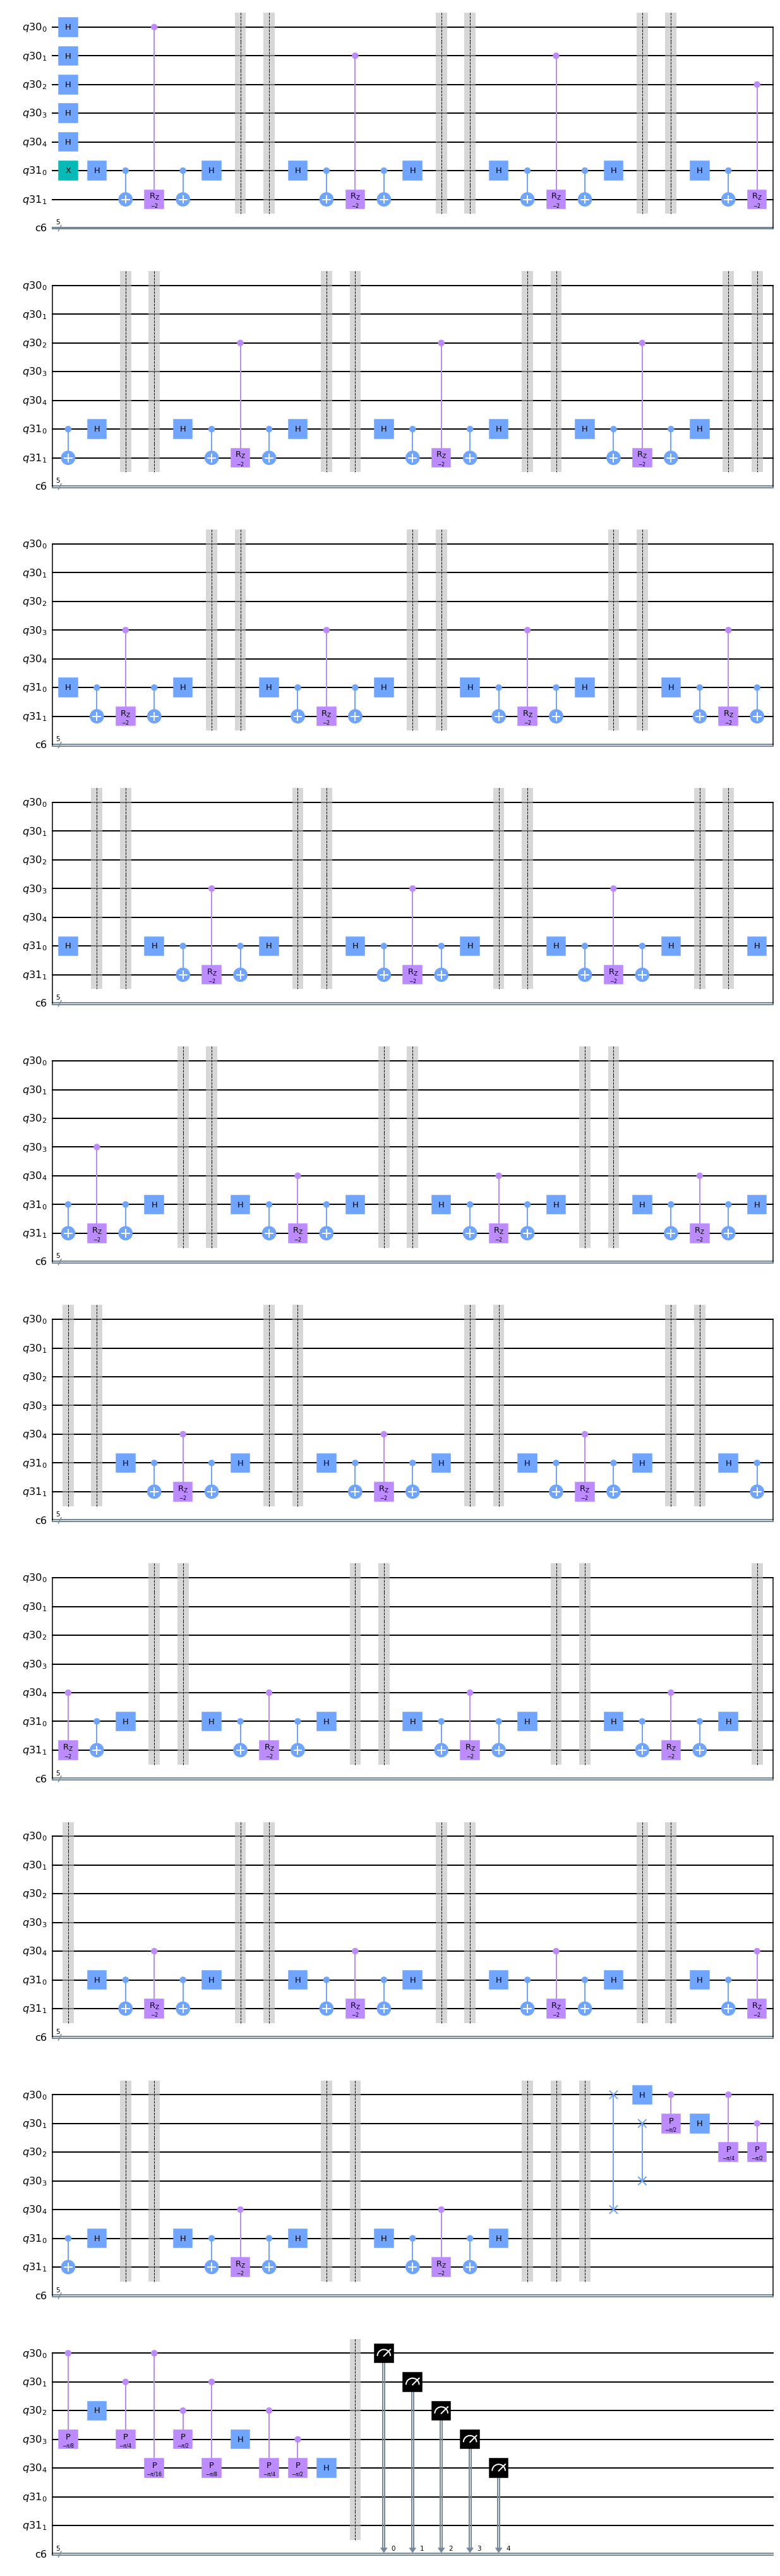

In [22]:
#We define the relevant constants for the simulation
p = 5
n = 1
epsilon = 0.1
t = 1
r = int(np.ceil(t**2/epsilon))
print(r)

#We then edfine our registers and circuit
cr = ClassicalRegister(p)
qr = QuantumRegister(p)
anc = QuantumRegister(n + 1)
test_FE = QuantumCircuit(qr, anc, cr)

#First we prepare the eigenstate we wish to investigate for.
test_FE.x(anc[0])

#With the following setup of theta, phi and lam, we get a controlled T-gate.
PhaseEst(test_FE, h_temp, p, r, t)

#We measure the first n qubits
test_FE.barrier()
test_FE.measure(np.arange(p), np.arange(p))

#Enable this to see the circuit
#test_FE.draw(output = 'mpl')

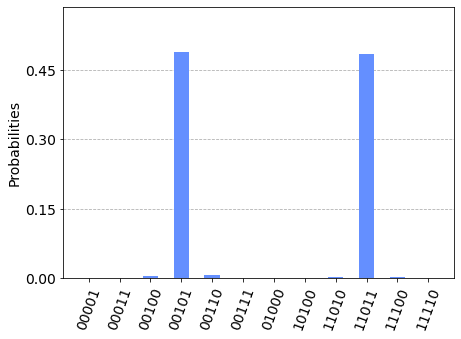

In [23]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024  # how many time execute the algorithm
job = execute(test_FE, backend, shots=shots)
result = job.result()
counts = result.get_counts()
plot_histogram(counts, bar_labels=False)

Here I classically calculate the eigenvalues with numpy.linalg

In [24]:
evals, _ = np.linalg.eig(h_temp)
print(evals)

[ 1. -1.]


And we convert the most common bitstring into an estimated phase an compare it to the classically determined eigenvalues.

In [27]:
#take the most often obtained result
phase_bits = max(counts, key=counts.get)

# Print out the most common string
print('\nThe most common bit is')
print(phase_bits)

#Then we determine the phase that correspond to
#the most common bitstring
phase = 0
for index, bit in enumerate((phase_bits)):
    phase += int(bit) / 2**(index + 1)

# Print out the estimated phase
print('\nAnd the corresponding phase is')
print(phase)

#And corrsponding, estimated eigenvalue
estimated = np.exp(2 * np.pi * 1j * phase / t)

# Print out the estimated eigenvalues
print("\nEigenvalue from QPE:")
print(estimated)

# Print out the actual eigenvalues
print("\nActual eigenvalues:")
print(set(sorted(evals, key=lambda x: abs(x)**2)))


The most common bit is
00101

And the corresponding phase is
0.15625

Eigenvalue from QPE:
(0.5555702330196023+0.8314696123025452j)

Actual eigenvalues:
{1.0, -1.0}
